# CNN Image Classifier

In this notebook, we improve on a simple MLP classifier by using convolutional layers.

## 1. Dataset

The first thing we need to do is load train and test datasets. We'll be usiing the CIFAR-10 dataset, which is a set of 60,000 32x32 RGB color images. It comes preinstalled with Keras.



In [ ]:
import numpy as np 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.datasets import cifar10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Scale pixel values to lie within $[0, 1]$.

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
number_of_categories=10

Convert class labels to one-hot encoding.

In [ ]:
y_train = to_categorical(y_train, num_classes=number_of_categories)
y_test = to_categorical(y_test, num_classes=number_of_categories)

Let's check out some of the images is `X_train`.

In [ ]:
import matplotlib.pyplot as plt

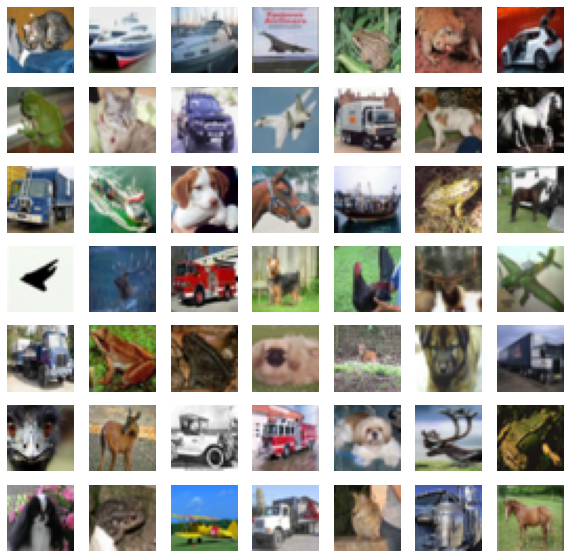

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(7 * 7):

    plt.subplot(7, 7, i+1)
    plt.imshow(X_test[i])
    plt.axis('off')

plt.show()
plt.close()

## 2. Convolutions

Given two time-varying functions $f(\tau)$ and $g(\tau)$, their convolution $f(\tau) * g(\tau)$ is a new function $h(t)$ which expresses the amount of overlap when $f$ is shifted over $g$.

![](https://media.giphy.com/media/L8FSxwyd2Nopq/giphy.gif)

In convolution neural networks, this idea is extended to two dimensions, where we consider the overlap between blocks of pixels. Since the time steps are discrete in this case, summations is used instead of integration. The size of the output image (called a feature map) depends on several kernel hyperparameters:

* The width and height of the kernel - larger kernels cut off more pixels at the edge of the input image (however padding can be used to reduce this).
* The horizontal and vertical stride - larger strides shrink the feature map.
* The amount of padding. As mentioned this can reduce the amount of cut-off resulting from the kernel size.

The values of the kernel are trainable parameters learned by the network. Essentially, the network is able to derive useful filters or "feature detectors" that are invariate to location -- an eye in the bottom left corner is has the same embedding as an eye in the top left. After several layers of pooling (downsampling) and convolution the filters are albe to pick out increasingly abstract patterns such as "eyes" or "heads". This higherarchical, compositional form of pattern recognition leads to excellent performance on image-like data. 

In 2D CNNs, filters also have an additional dimension (depth), which is equal to the number of channels within the image. For example:

![](https://i.stack.imgur.com/YCJRm.jpg)

In this image, we see a 3x3 kernel with depth 3 beign convolved over a 3x3x3 block of an image. The values of the kernel and image cube are multiplied point-wise and then summed together, resulting in a single scalar value.

So the overall value of a pixel in the resulting feature map depends on the kernel values in all three channels. Any number of channels can be used in general.

With this understanding, let's look at the `Convolutional2D` layer provided by Keras. Again, while the class name ends with `2D`, the computation performed are really a $n \times m \times c$ product-sum, where $c$ is the number of input channels. The convolution is called 2D because the direction of sliding is in two dimensions. Using this layer type, we can specify several hyperparameters including:

* Filter depth - the number of kernels used per filter in a convolutional layer. This value should always match the number of input channels. For example, an RGB image has three channels (red, green, blue), and a particular filter requires three separate kernels for each channel.

* Filter number - the number of filters used in a convolutional layer. Several filters (each of the same depth), can be applied to an input image - e.g. one might detect circles in any colour whereas another might look for black and white stripes. The number of filters used in a layer determines the number of channels passed to the next layer. So in this case, we would have two channels the "circles channel" and the "stripes channel".

So overall, the layer-to-layer computation is as follows:

* Take an input image with shame $w \times h \times c$ where $c$ is the number of channels (e.g. 3 for RGB).

* Apply $k$ filters to the image, each consisting of $c$ 2D convolve kernels. The kernels are slid over the image, resulting in $c$ feature maps. The feature maps summed point-wise to produce a final feature map.

* After all the $k$ filters have been applied, we will have a new image with $k$ channels (each channel containing one of the maps).  

* This new image is passed to the next layer.

* A flatten layer is placed between the final convolution (or pooling) layer and the dense network.

## 3. Model

Let's create a simple, CNN with two convolutional layers.

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense, Convolution2D, LeakyReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model

In [ ]:
X_train[0].shape

(32, 32, 3)

In [ ]:
inputs = Input(X_train[0].shape)

x = Convolution2D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x) # reduce internal covariate shift 
x = LeakyReLU()(x)

x = Convolution2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Convolution2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

outputs = Dense(number_of_categories, activation='softmax')(x)

model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                             

Let's now compile the model, using Adam as an optimizer and categorical cross-entropy as the loss function.

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
optimizer = Adam()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## 3. Training

Now we're ready to train the model. In this process, the model's parameters will be adjusted so as to minimize the loss function. It can be shown that minimizing cross-entropy is equivalent to maximizing the likelihood of the training data. Hence the estimator being used is in fact an MLE estimator.

In [ ]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    shuffle=True
)

Epoch 1/10
1563/1563 [==============================] - 180s 114ms/step - loss: 1.5013 - accuracy: 0.4685
Epoch 2/10
1563/1563 [==============================] - 176s 113ms/step - loss: 1.1220 - accuracy: 0.6045
Epoch 3/10
1563/1563 [==============================] - 176s 112ms/step - loss: 0.9893 - accuracy: 0.6537
Epoch 4/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.9001 - accuracy: 0.6849
Epoch 5/10
1563/1563 [==============================] - 174s 112ms/step - loss: 0.8453 - accuracy: 0.7053
Epoch 6/10
1563/1563 [==============================] - 174s 112ms/step - loss: 0.7971 - accuracy: 0.7220
Epoch 7/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.7547 - accuracy: 0.7364
Epoch 8/10
1563/1563 [==============================] - 174s 111ms/step - loss: 0.7180 - accuracy: 0.7496
Epoch 9/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.6828 - accuracy: 0.7608
Epoch 10/10
1563/1563 [=======================

## 4. Evaluation 

Finally, let's evaluate the model using the test dataset. This dataset consists of examples the model has yet to encounter. It's accuracy on this unseen data will give an indication as to how well it can approximate $p(\vec y\ |\ X)$ in general.

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 10s 32ms/step - loss: 0.8932 - accuracy: 0.7059


[0.8932299613952637, 0.7059000134468079]

We see that the model achieves ~71% on the test which is a considerable improvement from the simple MLP classifier.

Lastly, let's test the model on some examples:

In [ ]:
label_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [ ]:
def classify(images):

    predictions = model.predict(images)
    most_likely = np.argmax(predictions, axis=-1)

    return label_names[most_likely]

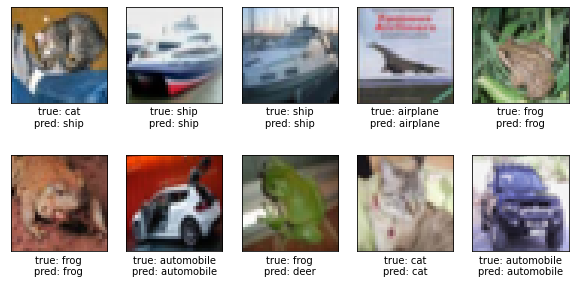

In [ ]:
model_labels = classify(X_test[0 : 10])


plt.figure(figsize=(10,5))


for i, model_label in enumerate(model_labels):

    axes = plt.subplot(2, 5, i+1)
    true_label = label_names[np.argmax(y_test[i])]
    axes.set_xlabel(f'true: {true_label}\npred: {model_label}')

    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])


plt.show()
plt.close()